# Describe the Dataset

In [1]:
from __future__ import division

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import shapely
import numpy as np
import scipy.stats as sp
import Pycluster as pc

%matplotlib inline

In [2]:
# DNAInfo Data
ny_data = r'C:\Users\djl543\OneDrive\Draw-Your-Neighborhood-master\NYC_Analysis_wgs84.geojson'
#ny_data = r'C:\Users\Dan\OneDrive\Draw-Your-Neighborhood-master\NYC_raw_wgs84.geojson'
ny_nhoods = gpd.read_file(ny_data)

# Set the crs of the input geojson to WGS84
ny_nhoods.crs = {'init': 'epsg:4326'}

# Tranform to projected coordinate system - EPSG:32118 - New York Long Island, NAD83-based projection in metres.
ny_nhoods = ny_nhoods.to_crs({'init':'epsg:32118'})

ny_nhoods.head()

,geometry,neighborhoodLive,nhood,otherNeighborhood,shapeID,yearsLived
0,"POLYGON ((311834.6421283125 77460.83003323362,...",Allerton,Allerton,,259,2
1,"POLYGON ((311305.0904452928 78317.74772848203,...",Allerton,Allerton,,298,0
2,"POLYGON ((311189.369271409 78288.7412320913, 3...",Allerton,Allerton,,5964,2
3,"POLYGON ((311199.2696228614 77331.72545915398,...",Allerton,Allerton,,59957,15
4,"POLYGON ((311137.8304619553 78879.66082988337,...",Allerton,Allerton,,61660,1


In [4]:
# Calculate the area of each drawing in square km
ny_nhoods['area'] = ny_nhoods['geometry'].area/1000000

# Calculate the isoperimetric quotient of each drawing
ny_nhoods['isoper'] = (ny_nhoods['geometry'].area * 4 * np.pi)/np.power(ny_nhoods['geometry'].length,2)

# Calculate the geometric centroid of each record
ny_nhoods['centroid'] = ny_nhoods['geometry'].centroid

# Work out neighborhood median centers based on drawing centroids

# Group the data
ny_grp = ny_nhoods.groupby('nhood')

# Now calulate 
n_hood_centroids = {}
count = 0
for nid, data in ny_grp:
    centroids = []
    for row in data.iterrows():
        centroids.append(np.array(row[1]['centroid']))
    ncenter, nmask = pc.clustercentroids(centroids,method='m')
    n_hood_centroids[count] = [nid,shapely.geometry.Point(ncenter[0]),len(data)]
    count+=1
    
# Finally, put the median center information and counts of drawings into a new geopandas dataframe
n_centroids = gpd.GeoDataFrame(n_hood_centroids).transpose()
# Name the columns
n_centroids.columns = ["neighborhood","geometry","count"]
# Add a rank column based upon the number of drawings
n_centroids['rank'] = n_centroids['count'].rank(ascending=False)
# Set the CRS of n-centroids
n_centroids.crs = {'init': 'epsg:32118'}

n_centroids.head()

# Let's add borough data so that we can aggregate by NYC borough

# New York City borough boundaries.
nyc = gpd.read_file(r'C:\Users\djl543\OneDrive\Draw-Your-Neighborhood-master\NYC.shp')

# Project to EPSG:32118 - New York Long Island, NAD83-based projection in metres.
nyc = nyc.to_crs({'init':'epsg:32118'})

# Do a spatial join of nyc on n_centroids (point in polygon)
n_centroids = gpd.sjoin(n_centroids, nyc, how="left", op='within')

# Now append the BoroName to the Drawings based on the neighborhood.
ny_nhoods = ny_nhoods.merge(n_centroids.ix[:,['neighborhood','BoroName']],left_on='nhood',right_on='neighborhood')
del ny_nhoods['neighborhood']

In [14]:
# Count of drawings by borough.
ny_nhoods.groupby('BoroName')['nhood'].count()

BoroName
Bronx             1758
Brooklyn         15035
Manhattan        15120
Queens            7464
Staten Island     1407
Name: nhood, dtype: int64

In [41]:
# Output some quick stats about mean count of drawings per neighborhoods by borough 
grps = ny_nhoods.groupby('BoroName')
borocounts = {}

for boro in ['Bronx','Brooklyn','Manhattan','Queens','Staten Island']:
    b = grps.get_group(boro)
    b = b.groupby('nhood')['nhood'].count()
    print boro
    print 'Mean:', b.mean()
    print 'Median:', b.median()
    print 'IQR:', np.percentile(b,25),',',np.percentile(b,75)
    print ""
    borocounts[boro] = b

print "Overall"
print 'Mean:', ny_nhoods.groupby('nhood')['nhood'].count().mean()
print 'Median:', ny_nhoods.groupby('nhood')['nhood'].count().median()
print 'IQR:', np.percentile(ny_nhoods.groupby('nhood')['nhood'].count(),25),',',np.percentile(ny_nhoods.groupby('nhood')['nhood'].count(),75)
print ""

Bronx
Mean: 37.4042553191
Median: 28.0
IQR: 12.0 , 46.5

Brooklyn
Mean: 259.224137931
Median: 129.5
IQR: 54.75 , 348.25

Manhattan
Mean: 252.0
Median: 129.0
IQR: 44.25 , 309.5

Queens
Mean: 113.090909091
Median: 54.5
IQR: 21.25 , 94.5

Staten Island
Mean: 27.0576923077
Median: 21.5
IQR: 10.75 , 32.5

Overall
Mean: 144.113074205
Median: 49.0
IQR: 18.5 , 138.0



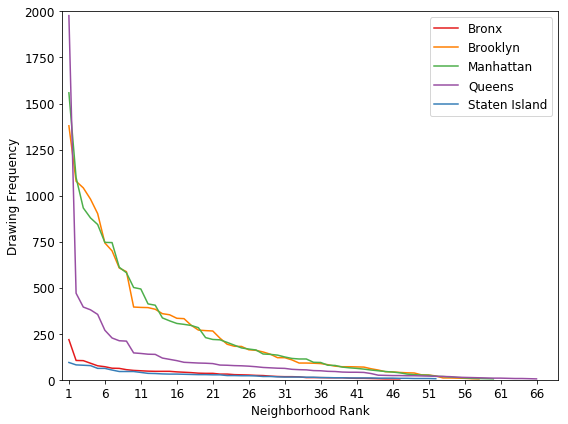

In [97]:
# Draw a figure showing the frequencies of drawings by neighborhoods, descending

fig, ax = plt.subplots(1,figsize=(8,6))

borocounts['Bronx'].sort_values(ascending=False).plot(ax=ax,c='#e41a1c')
borocounts['Brooklyn'].sort_values(ascending=False).plot(ax=ax, c='#ff7f00')
borocounts['Manhattan'].sort_values(ascending=False).plot(ax=ax, c='#4daf4a')
borocounts['Queens'].sort_values(ascending=False).plot(ax=ax, c='#984ea3')
borocounts['Staten Island'].sort_values(ascending=False).plot(ax=ax, c='#377eb8')

plt.ylabel("Drawing Frequency")
plt.xlabel("Neighborhood Rank")
plt.xticks(range(0,67,5),range(1,67,5))
plt.xlim((-1,68))
handles, labels = ax.get_legend_handles_labels()
labels = ['Bronx','Brooklyn','Manhattan','Queens','Staten Island']
plt.legend(handles,labels,prop={'size':12})
for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.ylim((0,2000))
plt.tight_layout()
plt.savefig('Figure1.tiff',dpi=300)

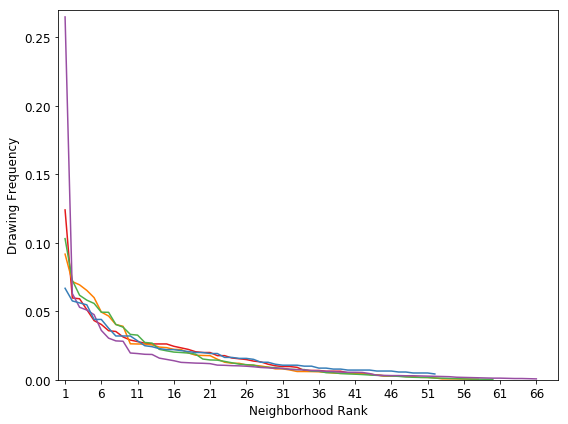

In [112]:
# Draw a figure showing the normed frequencies of drawings by neighborhoods, descending

fig, ax = plt.subplots(1,figsize=(8,6))

(borocounts['Bronx']/1758).sort_values(ascending=False).plot(ax=ax,c='#e41a1c')
(borocounts['Brooklyn']/15035).sort_values(ascending=False).plot(ax=ax, c='#ff7f00')
(borocounts['Manhattan']/15120).sort_values(ascending=False).plot(ax=ax, c='#4daf4a')
(borocounts['Queens']/7464).sort_values(ascending=False).plot(ax=ax, c='#984ea3')
(borocounts['Staten Island']/1407).sort_values(ascending=False).plot(ax=ax, c='#377eb8')

plt.ylabel("Drawing Frequency")
plt.xlabel("Neighborhood Rank")
plt.xticks(range(0,67,5),range(1,67,5))
plt.xlim((-1,68))
handles, labels = ax.get_legend_handles_labels()
labels = ['Bronx','Brooklyn','Manhattan','Queens','Staten Island']
#plt.legend(handles,labels,prop={'size':12})
for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.ylim((0,0.27))
plt.tight_layout()
plt.savefig('Figure1inset.tiff',dpi=300)

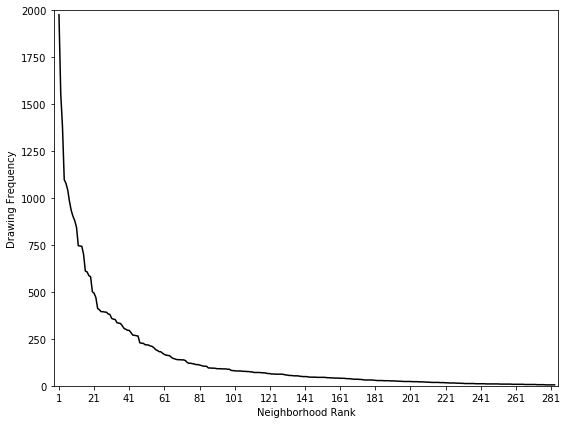

In [111]:
fig, ax = plt.subplots(1,figsize=(8,6))

# Plot for the whole dataset
ny_nhoods.groupby('nhood')['nhood'].count().sort_values(ascending=False).plot(c='k')
plt.ylabel("Drawing Frequency")
plt.xlabel("Neighborhood Rank")
plt.xticks(range(0,284,20),range(1,284,20))
plt.xlim((-3,284))
plt.ylim((0,2000))
plt.tight_layout()